# 等圧等温（NPT）アンサンブル

-----
## TL;DR

- NPT-MDシミュレーションでは圧力と温度が一定に制御される手法で、圧力制御（barostat）に関してはParrinello-Rahman法、Berendsen法の2種類が存在。
- 用途としては固体や流体の熱膨張、相転移、加圧状態のシミュレーション等
- Parrinello-Rahman法ではシミュレーションのセルの自由度が全て可変。pfactorを適切に設定する必要があり。
- Berendsen barostatではBerendsen thermostatと同様、非常に効率的に収束性良く制御可能。Berendsen barostatはセルの角度は固定して各セル長を独立に可変、もしくは各セル長の比率を固定する2つのモードで計算可能。compressibilityを入力パラメーターとして適切に設定が必要。

-----

このSectionでは圧力と温度の両方が一定となるような平衡状態を作る計算手法について説明します。一般に圧力制御の仕組みはbarostatと呼ばれ、一般にSection 6-2で出てきた熱浴法（thermostat）と同時に用いることで等温等圧アンサンブル（isothermal-isobaric ensemble、またはNPT）と呼ばれる状態分布を生成することを目的としてます。NPT-MDシミュレーションで（原理的に）検討可能な現象には

- 固体の熱膨張率
- 融点の予測
- 固体の相転移
- 流体（ガス、液体）の密度予測

etc.

が考えられます。*原理的*にという枕詞がついている理由は、これらの現象の再現性は計算に用いる力場の精度に大きく依存するためで、特に小さなエネルギー差に依存する分子間力や流体の状態予測は非常に難しいことが知られているからです。本チュートリアルでは比較的精度が高いと考えられる固体の事例を通してNPT-MDについて学んでいきます。

まずは本チュートリアルで利用する[ASEに実装されているNPT-MDの手法](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt)について確認します。2022年6月現在、ASEで標準的に利用可能な実装は以下の3種類が存在します。

| クラス名 | ensemble | パラメーター | 熱浴 | 圧力制御 | コメント |
|----------|----------|-------------|------|------|----------|
| NPT | NPT | 時定数($\tau_t$),圧力因子(*pfactor*) | Nosé–Hoover|Parrinello-Rahman| セルの全自由度が可変、制御可能 |
| NPTBerendsen | NPT | $\tau_t$,$\tau_P$,$\beta_T$ | Berendsen|Berendsen| セル形状は維持し体積変化のみ|
| InhomogeneousBerendsen | NPT | $\tau_t$,$\tau_P$,$\beta_T$ | Berendsen|Berendsen| セル角度は保持するが、圧力の異方性は考慮可能|

表中の２番目と３番目の手法はBerendsen barostatで本質的に同じものです。（ちなみに3番目の手法であるInhomogeneousBerendsenはASEのマニュアルで記載はないのですが、NPTBerendsenとともにASEのなかでクラスが定義されています。）したがって、ASEのフレームワーク内で使える機能としてはParrinello-Rahman法とBerendsen法の２種類のみになります。熱浴自体はSection 6-2で解説した手法が用いられているので、これらの熱浴法の特徴をよく考慮する必要があります。

それではまず、系の自由度と汎用性が比較的高いParrinnello-Rahman法を見てみましょう。

## Parrinello-Rahman法の運動方程式

Parrinello-Rahman法はいわゆる拡張系の計算手法で、Nosé–Hoover熱浴法の時のように、計算対象の系が仮想的に外部の一定温度、一定圧力の系と接続されていることを仮定します。この場合の運動方程式は下記のように記述されます。（導出の詳細については参考文献[1-3]をご確認ください。）

$$ \dot{\mathbf{x}_i} = \mathbf{p}_i/m_i + \eta(\mathbf{x}_i-\mathbf{R}_o) $$

$$ \dot{\mathbf{p}_i} = \mathbf{F_i}-(\eta+\zeta)\mathbf{p}_i $$

$$ \dot{\zeta} = \frac{1}{\tau_T^2}\left(\frac{T(t)}{T_o}-1\right)-3\eta\zeta $$

$$ \dot{s} = 3(N-1) s\zeta $$

$$ \dot{\mathbf{\eta}} = \frac{V}{\tau_P^2Nk_BT_o}\left(\mathbf{P(t)}-P_o\mathbf{I}\right)+3\frac{\tau_T^2}{\tau_P^2}\zeta^2\mathbf{I}$$

$$ \dot{\mathbf{h}}=\mathbf{\eta}\mathbf{h} $$


ここでNosé–Hoover熱浴以外の項に限定すると、圧力制御の時定数$\tau_P$、系の重心$R_o$, 目標の外圧$P_o$,シミュレーションセル体積$V$があります。$\eta$が圧力制御自由度を表す変数になっています。$\mathbf{h} = (\mathbf{a}, \mathbf{b}, \mathbf{c})$で$\mathbf{a},\mathbf{b},\mathbf{c}$はそれぞれシミュレーションセルの各辺を定義するセルベクトルです。

上記の方程式で温度$T_o$や圧力$A_o$以外にユーザーが設定しなければいけない値は$\tau_T$と$\tau_P$の2つがあります。それではまず、単純に$\tau_T$と$\tau_P$にを任意の値に設定した場合を以下に示します。ここで$\tau_T$を20 fsecとしています。$\tau_P$を直接指定しませんが、pfactorと呼ばれる値が$\tau_p^2B$となります。$B$はbulk modulusを指しており、この値をあらかじめ計算して指定する必要があります。しかし、$\tau_P$自体の正確な値が事前にわからないのでpfactorを特定する術がありません。また$B$の値も異方性を示す構造や異なるタイプの物質が混在する際は計算しようがありません。したがって、pfactorそのものの概ねの値を設定してbarostatの挙動を調べます。以下の例でも言及しますが、少なくとも金属の結晶系では約10$^6$  GPa$\cdot$fs$^2$ から10$^7$  GPa$\cdot$fs$^2$ のオーダーの値を用いると計算が安定して収束性も良いようです。それ以外の材料となる場合は念のため事前検討としてpfactorの値と体積変化の様子を確認しておくことをオススメします。

## 計算事例：熱膨張係数の計算

それではNPTアンサンブルの計算事例としてNosé–Hoover thermostatとParrinello-Rahman barostat（[ASEのNPTクラス](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt)）を使って固体の熱膨張係数を計算してみます。温度を変化させながら熱平衡状態を作り出し、その時の格子定数の平均値から各温度における熱膨張係数を算出します。

今回は簡単のためfcc-Cuを用いて計算を行います。計算に用いられるスクリプトは以下のとおりです。温度は200 Kから1000 Kまで100 K刻み、外圧は1 barとします。対象の構造はfcc-Cuを3x3x3 unit cellsに拡張して108原子で計算を行います。以下では高速性のためASAP3-EMT力場を用いていますが、PFPで計算する場合も全く同様です。時間ステップは1 fsで20 psのシミュレーションで十分に平衡状態に達します。

In [1]:
import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

calc_type = "EMT"
# calc_type = "PFP"

if calc_type == "EMT":
    # ASAP3-EMT calculator
    from asap3 import EMT
    calculator = EMT()
elif calc_type == "PFP":
    # PFP calculator
    from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
    from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
    estimator = Estimator(model_version="v2.0.0",calc_mode=EstimatorCalcMode.CRYSTAL_U0)
    calculator = ASECalculator(estimator)
else:
    raise ValueError(f"Wrong calc_type = {calc_type}!")


# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 3
atoms_in.pbc = True
print("atoms_in = ",atoms_in)

# input parameters
time_step    = 1.0    # fsec
#temperature = 300    # Kelvin
num_md_steps = 20000 
num_interval = 10

sigma   = 1.0     # External pressure in bar
ttime   = 20.0    # Time constant in fs
pfactor = 2e6     # Barostat parameter in GPa
temperature_list = [200,300,400,500,600,700,800,900,1000]

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")

    
# run MD
for i,temperature in enumerate(temperature_list):
    print("i,temperature = ",i,temperature)

    print(f"sigma = {sigma:.1e} bar")
    print(f"ttime = {ttime:.3f} fs")
    print(f"pfactor = {pfactor:.3f} GPa*fs^2")

    temperature_str = str(int(temperature)).zfill(4)
    output_filename = f"./output/ch6/fcc-Cu_3x3x3_NPT_{calc_type}_{temperature_str}K"
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"
    print("log_filename = ",log_filename)
    print("traj_filename = ",traj_filename)
    
    atoms = atoms_in.copy()
    atoms.calc = calculator
    
    # Set the momenta corresponding to T=300K
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)
    
    dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = sigma*units.bar,
          ttime = ttime*units.fs,
          pfactor = pfactor*units.GPa*(units.fs**2),
          logfile = log_filename,
          trajectory = traj_filename,
          loginterval=num_interval
          )
    
    print_interval = 1000 if calc_type == "EMT" else num_interval
    dyn.attach(print_dyn, interval=print_interval)
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
    dyn.run(num_md_steps)

atoms_in =  Atoms(symbols='Cu108', pbc=True, cell=[10.83, 10.83, 10.83])
i,temperature =  0 200
sigma = 1.0e+00 bar
ttime = 20.000 fs
pfactor = 2000000.000 GPa*fs^2
log_filename =  ./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0200K.log
traj_filename =  ./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0200K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
  1000   3.496    151.13    1.13  1.05  1.24  1.09  0.24  0.19  -0.05    1.264
  2000   3.880    160.90    0.98  1.26  0.92  0.76  0.11  0.21  0.13    2.205
  3000   4.490    194.60    0.79  1.39  0.61  0.36  -0.18  0.24  0.32    3.192
  4000   4.334    179.15    0.32  0.69  0.08  0.18  -0.23  0.39  0.07    4.107
  5000   4.756    176.63    0.24  0.25  0.09  0.37  -0.23  0.35  0.14    5.040
  6000   4.899    191.10    0.37  0.00  0.47  0.65  -0.32  0.27  0.21    5.979
  7000   5.522    183.53    -0.06  -0.32  0.13  0.01  -0.39  0.15  0.34    6.921
  8000   6.103    204.25    -0.35  -0.51  -0.25  -0.30  -0.06  0.22  0.2

結果を可視化してみると以下のようになります。

ここでは`read`関数に `index="::100"` を指定することでTrajectoryファイルから間隔を間引いた結果に対して可視化しています。
Cuは固体の構造を保っており、大きく動いているわけではありませんが、振動の動きによりセルサイズに変化があることがわかります。

In [3]:
from ase.io import Trajectory, read
from pfcc_extras.visualize.povray import traj_to_apng
from IPython.display import Image


traj = read("./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0900K.traj", index="::100")
traj_to_apng(traj, f"output/ch6/Fig6-3_fcc-Cu_3x3x3_NPT_EMT_0900K.png", rotation="10x,-10y,0z", clean=True, n_jobs=16)

Image(url="output/ch6/Fig6-3_fcc-Cu_3x3x3_NPT_EMT_0900K.png")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:   11.0s remaining:   11.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:   13.7s finished


In [4]:
from ase.io import Trajectory, read
from pfcc_extras.visualize.view import view_ngl


traj = read("./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0900K.traj", index="::100")
view_ngl(traj, replace_structure=True)

熱浴の時定数$\tau_t$は20 fs、圧力制御パラメーターであるpfactorは2e6 GPa$\cdot$fs$^2$としています。上記の計算条件で熱平衡状態にするため300 Kで20 psのNPT-MDシミュレーションを行った際のセル体積の時間変化の様子を確認してみましょう。以下のようなコードで特定温度におけるMDシミュレーションの結果であるtrajファイルを解析出来ます。

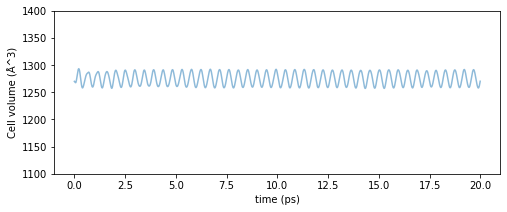

In [5]:
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io import read,Trajectory

time_step = 0.01  # Time step size in ps between each snapshots recorded in traj
traj = Trajectory("./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0300K.traj")

time = [ i*time_step for i in range(len(traj)) ]
volume = [ atoms.get_volume() for atoms in traj ]

# Create graph
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('time (ps)')  # x軸ラベル
ax.set_ylabel('Cell volume (Å^3)')  # y軸ラベル
ax.plot(time,volume, alpha=0.5)
ax.set_ylim([1100,1400])
#plt.savefig("filename.png")  # Set filename to be saved
plt.show()

上記コードを実行すると、以下のような解析結果が得られます。

この計算条件で熱平衡状態にするため300 Kで20 psのNPT-MDシミュレーションを行った際のセル体積の時間変化は以下のようになります。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPT_vol_vs_t.png"/>
    <figcaption align = "center">Fig.6-3a. Time evolution of cell volume. (fcc-Cu_3x3x3, @300 K and 1 bar)</figcaption>
</figure>
</br>

NPTアンサンブルで計算することでセル体積が約4%程の範囲で振動することが見て取れます。今回の計算対象は立方晶であるため、この体積の幾何平均から結晶の格子定数を計算出来ます。200 Kから1000 Kまで実行し、その各温度での規格化した格子定数の平均値をプロットすると以下の結果が得られます。

平衡状態に達したあとの格子定数を計算したいため、`np.mean(vol[int(len(vol)/2):])**(1/3)` の部分では、Trajectoryの後半半分のみを使用して、体積から格子定数を計算しています。

temperature =  [200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0200K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0300K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0400K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0500K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0600K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0700K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0800K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0900K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_1000K.traj
lat_a =  [10.821163632337704, 10.842839684174555, 10.866171596265199, 10.88848976153469, 10.912827783865225, 10.936618071520163, 10.9617904430426, 10.989222603709793, 11.018655524623599]
norm_lat_a =  [0.99800089 1.         1.00215183 1.00421016 1.00645478 1.00864888
 1.01097044 1.01350042 1.01621493]


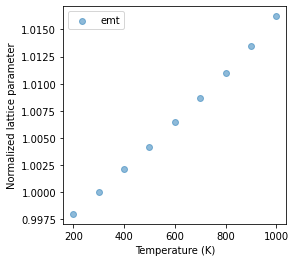

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ase.io import read,Trajectory

time_step = 10.0  # Time step size between each snapshots recorded in traj
paths = Path("./output/ch6/").glob(f"**/fcc-Cu_3x3x3_NPT_{calc_type}_*K.traj")
path_list = sorted([ p for p in paths ])

# Temperature list extracted from the filename
temperature = [ float(p.stem.split("_")[-1].replace("K","")) for p in path_list ]
print("temperature = ",temperature)

# Compute lattice parameter
lat_a = []
for path in path_list:
    print(f"path = {path}")
    traj = Trajectory(path)
    vol = [ atoms.get_volume() for atoms in traj ]
    lat_a.append(np.mean(vol[int(len(vol)/2):])**(1/3))
    
print("lat_a = ",lat_a)

# Normalize relative to the value at 300 K
norm_lat_a = lat_a/lat_a[1]
print("norm_lat_a = ",norm_lat_a)

# Plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Temperature (K)')  # x軸ラベル
ax.set_ylabel('Normalized lattice parameter')  # y軸ラベル
ax.scatter(temperature[:len(norm_lat_a)],norm_lat_a, alpha=0.5,label=calc_type.lower())
ax.legend(loc="upper left")

上記のコードを実行すると以下のようなプロットが得られます。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_NPT_a_vs_T.png"/>
    <figcaption align = "center">Fig.6-3b. Normalized lattice parameter as a function of temperature.</figcaption>
    <figcaption align = "center">          Experimental data is taken from Reference [4].</figcaption>
</figure>
</br>

この結果にはさらにPFPを用いた計算結果、および参考までに実験値を比較対象としています。EMTおよびPFPのデータ共に非常に良い一致を示しており、小さな差ではありますがPFPはより実験値に近い傾向を示しています。

この規格化した格子定数の温度依存性から線熱膨張係数（CTE、$\alpha$）を以下の関係式をもちいて算出します。

$$
\frac{a(T)}{a_{RT}} = 1 + \alpha \cdot T
$$

ここで$\alpha$が線熱膨張係数で、$a(T)$と$a_{RT}$は温度$T$と室温における格子定数です。以下がASAP3-EMT、PFP、実験値[4]のサマリーです。

||$\alpha$ (10$^{-5}$/K)|
|--|--|
|emt|2.23|
|pfp|2.13|
|exp|1.74|

計算誤差を考えると、いずれの計算結果も実験値とリーズナブルな範囲で一致していると考えてよいと思います。

このような手法でNPTアンサンブルのMDシミュレーションを用いることによって熱膨張係数を算出することが可能です。

最後に補足として言及しますと、「液体や気体の熱膨張も同様の手法で再現できるのでは？」と考えるかと思います。原理的には確かにその通りなのですが、現時点では再現性の良いモデルというのは限定的と思われます。古典力場で特定の液体や気体のみに特化したモデルは存在するのかもしれませんが、第一原理計算を用いた場合、液体や気体では固体に比べて非常に小さい分子間相互作用の精度が重要になり、現在ではそのような精度の量子化学計算自体が非常に困難です。特にNNPを作成する際には膨大な計算データが必要になり、高精度な量子化学計算を多量に行うのは現時点であまり現実的ではありません。従って今後この領域での精度が高いモデルの開発が期待されるところです。

## [Advanced] Parrinello-Rahman barostatのパラメーター依存性

NPTアンサンブルでのMDシミュレーションを行う際にpfactorというパラメーターを設定する必要があり、適切な値の範囲が
10$^6$ GPa$\cdot$fs$^2$から10$^7$ GPa$\cdot$fs$^2$付近という説明がありました。ご参考までにpfactorの値を変化し際の結果を以下に示します。計算対象は上記と同じfcc-Cuの3x3x3 unit cellsで、温度は300 Kです。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPT_vol_vs_t_pfactor.png"/>
    <figcaption align = "center">Fig.6-3c. Time evolution of cell volume as a function of pfactor.</figcaption>
</figure>
</br>

pfactorが小さい領域では高速でセル体積が振動しており、高周波と低周波の振動が混在していて挙動が不安定な領域もあるのであまり好ましくありません。pfactorが大きくなるにつれて振動の周期が徐々に長くなり、小さなpfactorの計算初期で起きるの大きなセル体積の変化も殆ど見られません。明確にpfactorのどの値から使うと良いという指標があるわけではないですが、10$^6$ Ga$\cdot$fsec$^2$以上であれば小さな振動は確認できるものの中央値は相変わらず安定しているようです。上限についても同様で明確な基準はなく、pfactorが大きいと振動周期が長くなり扱いづらいので、上記の例に関していえば10$^6$から10$^7$ぐらいが妥当な領域かと考えます。

##  [Advanced] Berendsen barostatのパラメーター依存性

Berendsen barostatを用いた計算方法について説明します。Berendsen barostatは以下の方程式に従って圧力の時間発展が計算されます。（導出の詳細は参考文献[5]をご覧ください。）

$$
\frac{d\mathbf{P}}{dt}=\frac{\mathbf{P}_o-\mathbf{P}}{\tau_P}
$$

上式から明らかなように、Berendsen圧力制御法では指数関数的に系の各瞬間における圧力を外圧$\mathbf{P}_o$に近づけていきます。その速度は時定数$\tau_P$により制御されます。

各MDステップ毎に、各原子の座標とセルベクトルは以下の式で表される係数でスケーリングされます。

$$
\mu_{ij}=\delta_{ij}-\frac{\Delta t}{3\tau_P}\beta_{ij}\big\{ P_{oij} - P_{ij}(t) \big\}
$$

熱浴のコントロールの際に$\tau_T$が時定数だったように、圧力制御法でも適切な時定数${\tau_P}$を設定してやる必要があります。それでは実際の計算事例を見てみましょう。

ASEの機能である[NPTBerendsenクラス](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt)を用いるとdynamicsを定義するオブジェクトは以下の形で記述されます。

In [7]:
from ase.md.nptberendsen import NPTBerendsen

dyn = NPTBerendsen(
    atoms,
    time_step*units.fs,
    temperature_K = temperature,
    pressure_au = 1.0 * units.bar,
    taut = 5.0 * units.fs,
    taup = 500.0 * units.fs,
    compressibility_au = 5e-7 / units.bar,
    logfile = log_filename,
    trajectory = traj_filename,
    loginterval=num_interval
)

`Inhomogeneous_NPTBerendsen`もほぼ同様の設定です。（クラス名を`NPTBerendsen`から`Inhomogeneous_NPTBerendsen`とすることで利用可能です。）１点異なるのはmaskが設定でき、`mask=(1, 1, 1)`とするとa,b,c方向全て独立して変化可能です。このtupleの要素を0と設定することでその方向でcellが固定されます。

いずれのBerendsen barostatでも注意が必要なのは温度、圧力のような計算条件以外に、圧力制御時定数(`taup`、$\tau_P$）や圧縮率（`compressibility`、$\beta_T$）と呼ばれるパラメーターを設定する必要があることです。それぞれの値に対するセル体積の時間変化の依存性を300 Kにおけるfcc-Cuの例を用いて確認します。まずは$\tau_P$の方からみてみます。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPTBerendsen_vol_vs_t_taup.png"/>
    <figcaption align = "center">Fig.6-3d. Time evolution of cell volume as a function of $\tau_P$.</figcaption>
</figure>
</br>

時定数が小さいほど振動の周期が不安定で大きく暴れ、逆にあまり大きくとりすぎると変化があまりに緩やかで平衡に至るまでの時間がかかります。この辺りは熱浴法の時定数と同じ考え方です。力学的にfcc-Cuと類似の系に関しては体積変化の安定性と収束性から$\tau_P$は10$^2$ fsから10$^3$ fs付近が適切なようです。

次に$\beta_T$に対する依存性です。結果は以下のとおりです。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPTBerendsen_vol_vs_t_comp.png"/>
    <figcaption align = "center">Fig.6-3e. Time evolution of cell volume as a function of $\beta_T$.</figcaption>
</figure>
</br>

$\beta_T$が小さいほど収束が非常に遅く、高い値にあるほど不安定になっていく様子がうかがえます。グラフの傾向から$\beta_T$は10$^{-7}$から10$^{-6}$fs位が良さそうです。

$\tau_P$と$\beta_T$に関してはいずれも厳密に正しい値というものは無く、おおよそ桁で値を変えた時にこの程度傾向が変化するということを理解しておけば概ね問題はなさそうです。

最後に補足すると、これらの数値はあくまでfcc-Cuのような金属で密な構造を持つ物質について適用出来ますが、もし全く異なる系統の物質（例えばポリマー、液体、気体等）をNPTで扱いたいとなれば事前検討でこれらの適切な値の領域を確認しておく必要があります。手間を惜しんで事前検討を省くと意図しない結果が得られて余計に時間がかかるなどになりかねないので、通常、新しい材料系に取り組む際は注意されることをお勧めします。

## 参考文献：

[1] M.E. Tuckerman, "Statistical mechanics: Theory and molecular simulation", Oxford University Press (2010) ISBN 978-0-19-852526-4. https://global.oup.com/academic/product/statistical-mechanics-9780198525264?q=Statistical%20mechanics:%20Theory%20and%20molecular%20simulation&cc=gb&lang=en#

[2] Melchionna S. (2000) "Constrained systems and statistical distribution", Physical Review E 61 (6) 6165
https://journals.aps.org/pre/abstract/10.1103/PhysRevE.61.6165

[3] S. Melchionna, G. Ciccotti, B.L. Holian, "Hoover NPT dynamics for systems varying in shape and size", Molecular Physics, (1993) 78 (3) 533
https://doi.org/10.1080/00268979300100371

[4] F.C. Nix, D. MacNair, "NIST:The Thermal Expansion of Pure Metals: Copper, Gold, Aluminum, Nickel, and Iron"
https://materialsdata.nist.gov/handle/11256/32

[5] H. J. C. Berendsen, J. P. M. Postma, W. F. van Gunsteren, A. DiNola, and J. R. Haak, "Molecular dynamics with coupling to an external bath", J. Chem. Phys. (1984) 81 3684
https://aip.scitation.org/doi/10.1063/1.448118